In [ ]:
import os
import numpy as np
import pandas as pd
import yaml
import bayes_opt
from chspy import CubicHermiteSpline
from bayes_opt import BayesianOptimization
from bayes_opt.util import load_logs
from bayes_opt.event import Events
from bayes_opt.logger import JSONLogger
from scipy.optimize import NonlinearConstraint
import matplotlib.pyplot as plt
import seaborn as sns


# Define the path for saving/loading optimization progress
SAVE_PATH = "/Users/nathanirniger/Desktop/Bayes/bayesian_optimization_progress_y.json"

# Track scores for real-time visualization
score_history = []


In [2]:
def cubic_hermite_spline(points):
    spline = CubicHermiteSpline(n=1)
    for t, value, derivative in points:
        spline.add((t, [value], [derivative]))
    return spline

def validate_constraints(force2_start_time, force2_peak_time, force2_end_time):
    if force2_end_time <= force2_start_time:
        return False
    if force2_peak_time <= force2_start_time:
        return False
    return True

def save_optimization_results(base_profile, score, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time):
    try:
        os.makedirs("/Users/nathanirniger/Desktop/profiles/optim/plots", exist_ok=True)
    except Exception as e:
        print(f"Error creating directories: {e}")

    # Save the profile as CSV
    profile_path = f"/Users/nathanirniger/Desktop/profiles/optim/score_{score}_profile.csv"
    base_profile.to_csv(profile_path, index=False)

    # Plot the profile and save the figure
    target_profile = pd.read_csv("/Users/nathanirniger/Desktop/profiles/reference_profile_3.csv")
    plt.figure(figsize=(10, 6))
    plt.plot(base_profile["force_Y"], label="Optimized Profile Y Force")
    plt.plot(target_profile["force_Y"], label="Target Profile Y Force", linestyle="--")
    plt.legend()
    plt.title(f"Score: {score}")
    plt.savefig(f"/Users/nathanirniger/Desktop/profiles/optim/plots/score_{score}_profile_t21_{force2_start_time}_t22_{force2_peak_time}_f21_{force2_peak_force}_t23_{force2_end_time}.png")
    plt.close()

def plot_scores():
    plt.figure(figsize=(10, 6))
    plt.plot(score_history, label="Score History")
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title("Optimization Score Trend")
    plt.legend()
    plt.show()

In [13]:
def get_profile(force2_start_time, force2_peak_time, force2_peak_force, force2_end_time):
    max_force = 65  # Maximum force for the profile
    max_time = 360  # Maximum time for the profile


    force2_start_time = force2_start_time * max_time
    force2_peak_time = force2_peak_time * max_time
    force2_peak_force = force2_peak_force * max_force
    force2_end_time = force2_end_time * max_time

    # Load calibration data
    calibration_path = "/Users/nathanirniger/Desktop/profiles/device_height_calibration.yaml"
    with open(calibration_path, 'r') as file:
        data = yaml.safe_load(file)

    length = len(data['theta_2_values'])
    base_profile = pd.DataFrame({"force_X": np.zeros(length), "force_Y": np.zeros(length), "theta_2": data['theta_2_values']})

    # Y Force Profile
    grf_y = cubic_hermite_spline([(0, 0, 0), (force2_peak_time - force2_start_time, force2_peak_force, 0), (force2_end_time - force2_start_time, 0, 0)])
    curve_y = [grf_y.get_state(i)[0] for i in range(int(np.round(force2_end_time - force2_start_time)))]
    padded_curve_y = np.concatenate([np.zeros(int(np.round(force2_start_time))), curve_y, np.zeros(length - len(curve_y) - int(np.round(force2_start_time)))])

    base_profile["force_Y"] = padded_curve_y

    return base_profile

In [5]:
def easy_score(force2_start_time, force2_peak_time, force2_peak_force, force2_end_time):

    force2_start_time_target = 0.2
    force2_peak_time_target = 0.5
    force2_peak_force_target = 0.8
    force2_end_time_target = 0.7

    # score = np.abs(force1_end_time - force1_end_time_target) + np.abs(force1_peak_force - force1_peak_force_target) + np.abs(force2_start_time - force2_start_time_target) + np.abs(force2_peak_time - force2_peak_time_target) + np.abs(force2_peak_force - force2_peak_force_target) + np.abs(force2_end_time - force2_end_time_target)
    score = (force2_start_time - force2_start_time_target)**2 + (force2_peak_time - force2_peak_time_target)**2 + (force2_peak_force - force2_peak_force_target)**2 + (force2_end_time - force2_end_time_target)**2
    return -score

In [15]:
def objective(force2_start_time, force2_peak_time, force2_peak_force, force2_end_time):

    # Constraint: Ensure valid parameter relationships
    if not validate_constraints(force2_start_time, force2_peak_time, force2_end_time):
        return -1 # Penalty for violating constraints

    base_profile = get_profile(force2_start_time, force2_peak_time, force2_peak_force, force2_end_time)
    score = easy_score(force2_start_time, force2_peak_time, force2_peak_force, force2_end_time)

    # Log scores for visualization
    score_history.append(score)
    # Log results
    if score > -0.09:
        save_optimization_results(base_profile, score, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time)

    return score

In [9]:
pbounds = {
    "force2_start_time": (0.0, 1.0),      # Start time for force2
    "force2_peak_time": (0.0, 1.0),       # Peak time for force2
    "force2_peak_force": (0.0, 1.0),      # Peak force for force2
    "force2_end_time": (0.0, 1.0)         # End time for force2
}


def load_optimizer(kappa):
    # constraint = NonlinearConstraint(constraint_func, lb=-1, ub=0)
    acquisition = bayes_opt.acquisition.UpperConfidenceBound(kappa=kappa)

    optimizer = BayesianOptimization(
        f=objective,
        pbounds=pbounds,                   # Parameter bounds
        acquisition_function=acquisition,  # Acquisition function: Upper Confidence Bound
        # constraint=constraint,             # Constraint
        random_state=0,                    # Random seed accepts integer value and is used for reproducibility.
        verbose=2                          # Verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    )
    
    if os.path.exists(SAVE_PATH):
        load_logs(optimizer, logs=[SAVE_PATH])
        print("Loaded optimization progress from file.")
    else:
        print("No saved progress found. Starting a new optimization.")
        
    return optimizer

# Save progress using a JSONLogger
def save_progress(optimizer):
    logger = JSONLogger(path=SAVE_PATH)
    optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)


def explorate(optimizer, init_points=10, n_iter=0):
    optimizer.maximize(
        init_points=init_points,  # Number of random initial points
        n_iter=n_iter,            # Number of optimization iterations
    )

def optimize(optimizer, init_points=0, n_iter=1):
    optimizer.maximize(
        init_points=init_points,  # Number of random initial points
        n_iter=n_iter,            # Number of optimization iterations
    )


No saved progress found. Starting a new optimization.
Best parameters found: {'force2_end_time': 0.6854792929090245, 'force2_peak_force': 0.7458482976212655, 'force2_peak_time': 0.46635402722438346, 'force2_start_time': 0.2057829004222418}
Best score: -0.004308751226248044


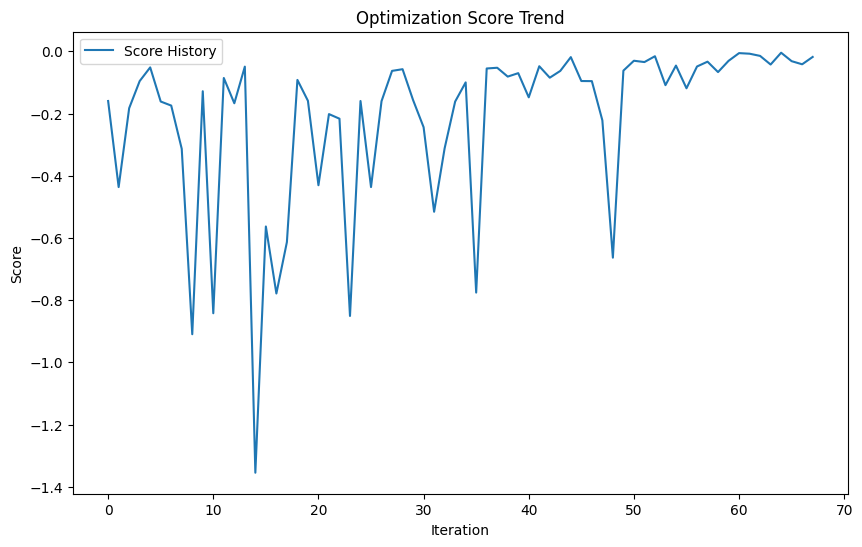

In [16]:
optimizer = load_optimizer(kappa=2.5)
save_progress(optimizer)

# Run initial exploration
explorate(optimizer)

# Run optimization
for i in range(50):
    optimize(optimizer)

# Output the best parameters and score
print("Best parameters found:", optimizer.max["params"])
print("Best score:", optimizer.max["target"])

# Plot the optimization score trend
plot_scores()

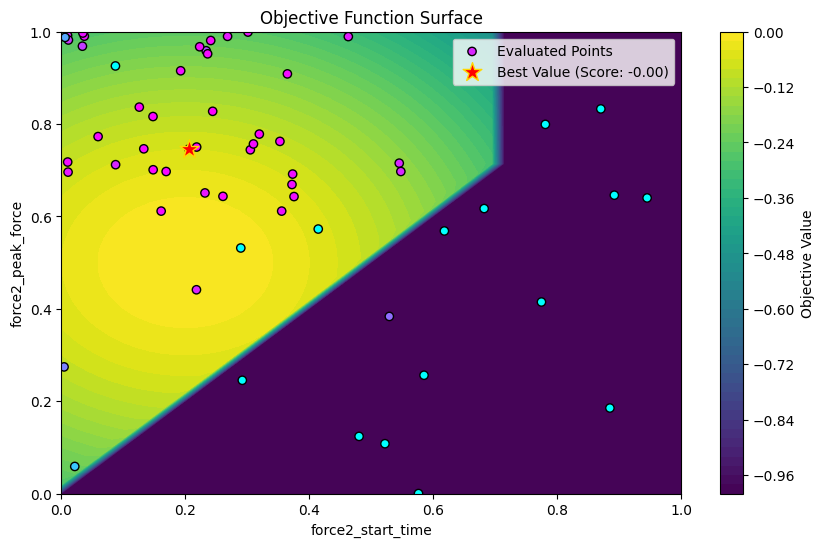

In [ ]:
def visualize_objective_surface():
    # Use a 2D slice for simplicity (vary two parameters, fix others)
    x = np.linspace(0.0, 1.0, 50)  # Adjust these ranges to match pbounds
    y = np.linspace(0.0, 1.0, 50)  # Adjust these ranges to match pbounds
    X, Y = np.meshgrid(x, y)

    # Fix other parameters for the visualization
    force2_start_time = 0.2
    force2_peak_time = 0.5
    force2_peak_force = 0.8
    force2_end_time = 0.7


    # force2_start_time, force2_peak_time, force2_peak_force, force2_end_time

    # Compute objective values for each combination of x, y
    Z = np.array([objective(xi, yi, force2_peak_force, force2_end_time) for xi, yi in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)

    # Plot the contour
    plt.figure(figsize=(10, 6))
    contour = plt.contourf(X, Y, Z, levels=50, cmap="viridis")
    plt.colorbar(contour, label="Objective Value")
    plt.xlabel("force2_start_time")
    plt.ylabel("force2_peak_force")
    plt.title("Objective Function Surface")
    

    # Add evaluated points from optimizer.res
    evaluated_x = []
    evaluated_y = []
    evaluated_scores = []
    
    for res in optimizer.res:
        evaluated_x.append(res["params"]["force2_start_time"])
        evaluated_y.append(res["params"]["force2_peak_force"])
        evaluated_scores.append(res["target"])
    
    plt.scatter(evaluated_x, evaluated_y, c=evaluated_scores, cmap="cool", edgecolor="k", label="Evaluated Points")

    # Highlight the best point with a star
    best_params = optimizer.max["params"]
    best_x = best_params["force2_start_time"]
    best_y = best_params["force2_peak_force"]
    best_score = optimizer.max["target"]

    plt.scatter([best_x], [best_y], color="red", edgecolor="gold", marker="*", s=200, label=f"Best Value (Score: {best_score:.4f})")

    plt.legend()
    plt.show()

# Visualize the objective function surface
visualize_objective_surface()

In [ ]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)


def visualize_objective_surface_interactive(optimizer):
    # Use a 2D slice for simplicity (vary two parameters, fix others)
    x = np.linspace(0.0, 1.0, 50)  # Adjust these ranges to match pbounds
    y = np.linspace(0.0, 1.0, 50)  # Adjust these ranges to match pbounds
    X, Y = np.meshgrid(x, y)

    force2_start_time = 0.2
    force2_peak_time = 0.5
    force2_peak_force = 0.8
    force2_end_time = 0.7


    # force2_start_time, force2_peak_time, force2_peak_force, force2_end_time
    # Compute objective values for each combination of x, y
    Z = np.array([objective(xi, yi, force2_peak_force, force2_end_time) for xi, yi in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)

    # Extract evaluated points from optimizer.res
    evaluated_x = []
    evaluated_y = []
    evaluated_scores = []

    for res in optimizer.res:
        evaluated_x.append(res["params"]["force2_start_time"])
        evaluated_y.append(res["params"]["force2_peak_force"])
        evaluated_scores.append(res["target"])

    # Extract the best point
    best_params = optimizer.max["params"]
    best_x = best_params["force2_start_time"]
    best_y = best_params["force2_peak_force"]
    best_score = optimizer.max["target"]

    # Create the interactive plot
    fig = go.Figure()

    # Add the contour surface
    fig.add_trace(go.Contour(
        x=x, y=y, z=Z,
        colorscale="Viridis",
        colorbar=dict(title="Objective Value"),
        contours=dict(showlabels=True),
        name="Objective Surface"
    ))

    # Add evaluated points
    fig.add_trace(go.Scatter(
        x=evaluated_x, y=evaluated_y,
        mode='markers',
        marker=dict(
            size=8,
            color=evaluated_scores,
            colorscale="Cividis",
            showscale=True,
            colorbar=dict(title="Score")
        ),
        name="Evaluated Points"
    ))

    # Add the best point
    fig.add_trace(go.Scatter(
        x=[best_x], y=[best_y],
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='star',
            line=dict(width=2, color='gold')
        ),
        name=f"Best Value (Score: {best_score:.2f})"
    ))

    # Update layout for better visualization
    fig.update_layout(
        title="Interactive Objective Function Surface",
        xaxis_title="force2_start_time",
        yaxis_title="force2_peak_force",
        legend=dict(yanchor="top", y=0.9, xanchor="left", x=0.01),
        template="plotly"
    )

    # Show the interactive plot
    # fig.show()
    iplot(fig)

# Example usage:
visualize_objective_surface_interactive(optimizer)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

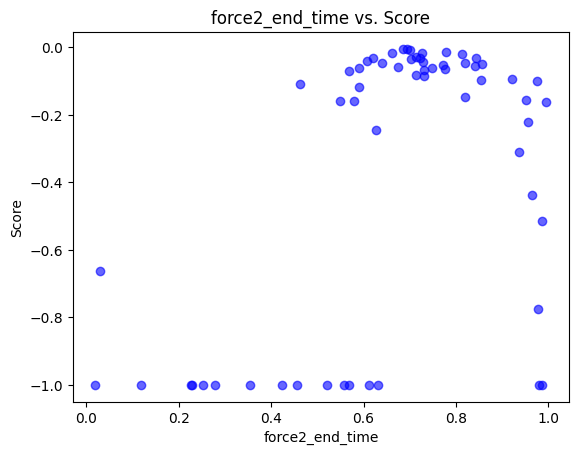

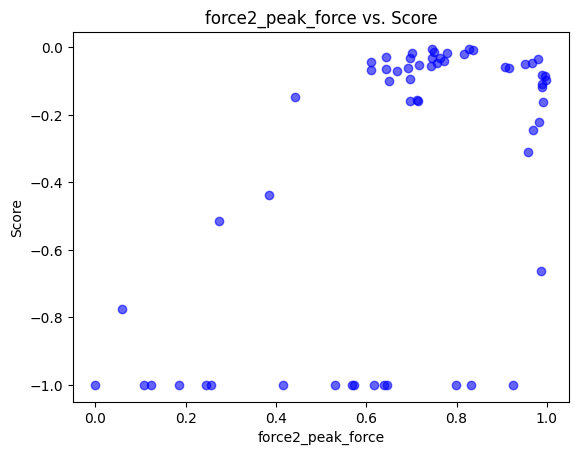

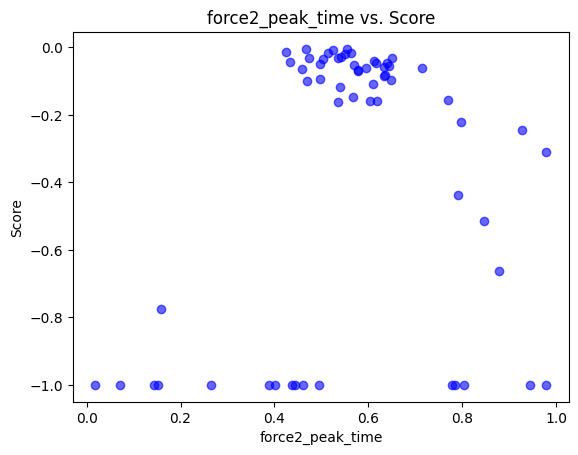

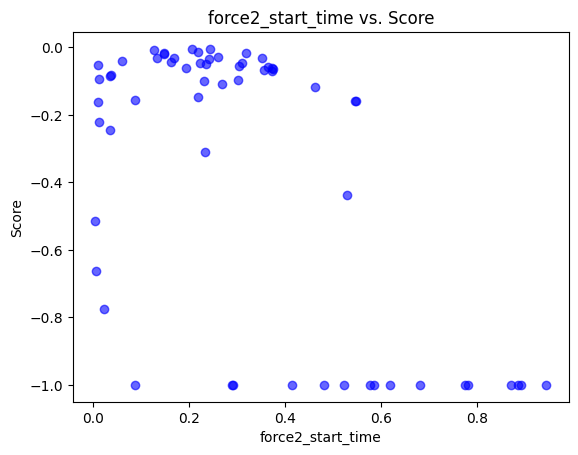

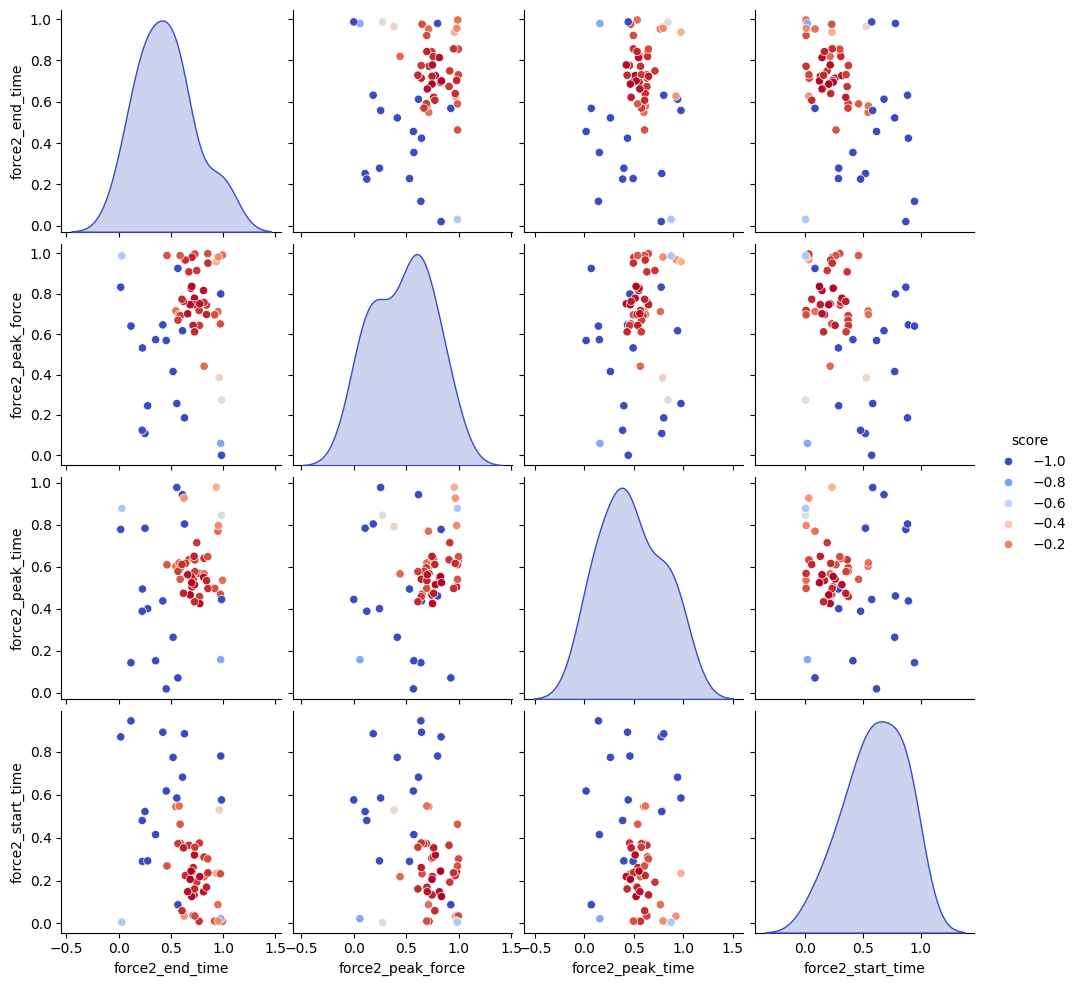

In [21]:
# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame([res['params'] | {'score': res['target']} for res in optimizer.res])

# 1D parameter vs. score plots
for param in results_df.columns[:-1]:  # Exclude score
    plt.figure()
    plt.scatter(results_df[param], results_df['score'], c='blue', alpha=0.6)
    plt.xlabel(param)
    plt.ylabel('Score')
    plt.title(f'{param} vs. Score')
    plt.show()

# 2D pair plots for selected parameters
sns.pairplot(results_df, vars=results_df.columns[:-1], hue='score', palette="coolwarm", diag_kind="kde")
plt.show()

/var/folders/2r/11xslhkj4dv68497dqcmks200000gn/T/ipykernel_65949/1146736612.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scores[i, j], stds[i,j] = optimizer._gp.predict([[x, y, force2_peak_force_target, force2_end_time_target]], return_std=True)
/var/folders/2r/11xslhkj4dv68497dqcmks200000gn/T/ipykernel_65949/1146736612.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scores[i, j], stds[i,j] = optimizer._gp.predict([[x, y, force2_peak_force_target, force2_end_time_target]], return_std=True)
/var/folders/2r/11xslhkj4dv68497dqcmks200000gn/T/ipykernel_65949/1146736612.py:20: DeprecationWarning: Conversion of an array with ndim > 

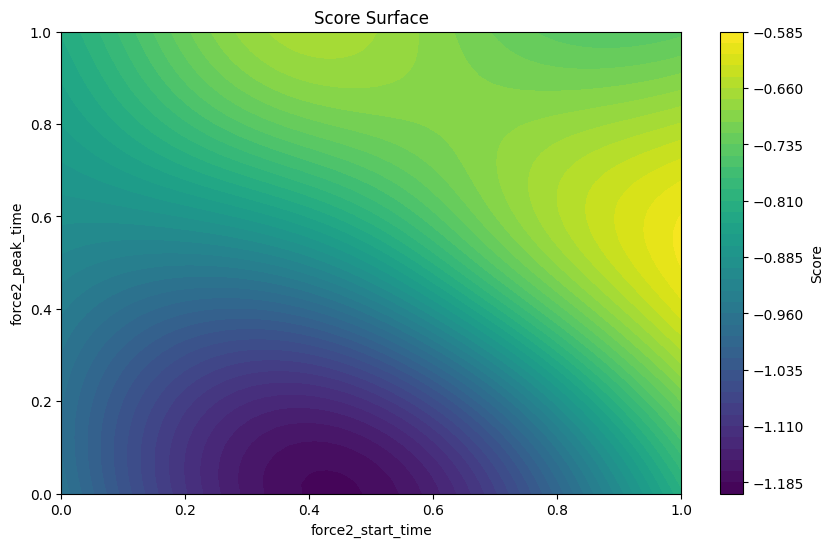

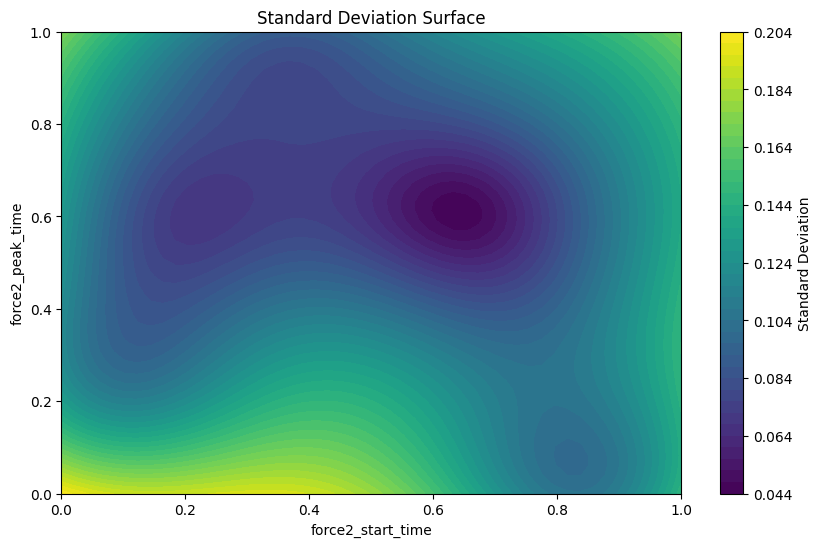

In [23]:
param_x = 'force2_start_time'
param_y = 'force2_peak_time'

force2_start_time_target = 0.2
force2_peak_time_target = 0.5
force2_peak_force_target = 0.8
force2_end_time_target = 0.7

# Generate a grid for two parameters
x_vals = np.linspace(pbounds[param_x][0], pbounds[param_x][1], 50)
y_vals = np.linspace(pbounds[param_y][0], pbounds[param_y][1], 50)
scores = np.zeros((len(x_vals), len(y_vals)))
stds = np.zeros((len(x_vals), len(y_vals)))

# Populate grid with scores from previously evaluated points
for i, x in enumerate(x_vals):
    for j, y in enumerate(y_vals):
        params = {param_x: x, param_y: y}
        # Use the GP model to predict the score at each point
        scores[i, j], stds[i,j] = optimizer._gp.predict([[x, y, force2_peak_force_target, force2_end_time_target]], return_std=True)


# Plot the scores and stds
plt.figure(figsize=(10, 6))
plt.contourf(x_vals, y_vals, scores, levels=50, cmap="viridis")
plt.colorbar(label="Score")
plt.xlabel(param_x)
plt.ylabel(param_y)
plt.title("Score Surface")
plt.show()

# Plot the stds
plt.figure(figsize=(10, 6))
plt.contourf(x_vals, y_vals, stds, levels=50, cmap="viridis")
plt.colorbar(label="Standard Deviation")
plt.xlabel(param_x)
plt.ylabel(param_y)
plt.title("Standard Deviation Surface")
plt.show()

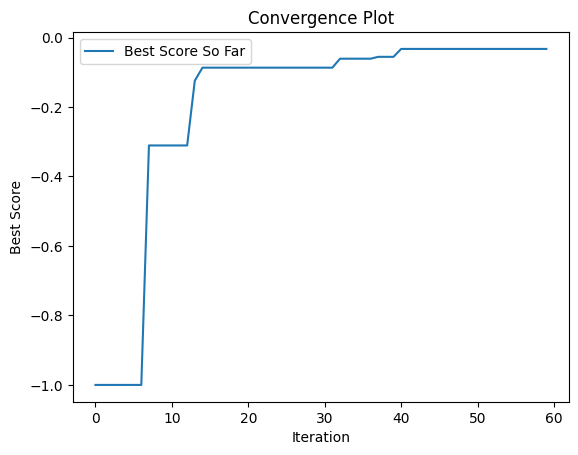

In [19]:
best_scores = [max([res["target"] for res in optimizer.res[:i+1]]) for i in range(len(optimizer.res))]

plt.plot(best_scores, label='Best Score So Far')
plt.xlabel('Iteration')
plt.ylabel('Best Score')
plt.title('Convergence Plot')
plt.legend()
plt.show()


In [22]:


# Example with two parameters
x_vals = np.linspace(pbounds[param_x][0], pbounds[param_x][1], 50)
y_vals = np.linspace(pbounds[param_y][0], pbounds[param_y][1], 50)
acq_values = np.zeros((len(x_vals), len(y_vals)))

for i, x in enumerate(x_vals):
    for j, y in enumerate(y_vals):
        acq_values[i, j] = optimizer.acq_func.utility([[x, y]], optimizer._gp, 0)

plt.imshow(acq_values, extent=(x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]), origin='lower', cmap='hot', aspect='auto')
plt.colorbar(label='Acquisition Value')
plt.xlabel(param_x)
plt.ylabel(param_y)
plt.title('Acquisition Function Landscape')
plt.show()


KeyboardInterrupt: 